# Define relative utilities

In [1]:
#__conv_utils__

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from six.moves import range
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, Lambda, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.layers.normalization import BatchNormalization

from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

from keras.datasets import cifar10
from keras.utils import np_utils

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import pickle

def normalize_tuple(value, n, name):
    """Transforms a single int or iterable of ints into an int tuple.
    # Arguments
        value: The value to validate and convert. Could be an int, or any iterable
          of ints.
        n: The size of the tuple to be returned.
        name: The name of the argument being validated, e.g. `strides` or
          `kernel_size`. This is only used to format error messages.
    # Returns
        A tuple of n integers.
    # Raises
        ValueError: If something else than an int/long or iterable thereof was
        passed.
    """
    if isinstance(value, int):
        return (value,) * n
    else:
        try:
            value_tuple = tuple(value)
        except TypeError:
            raise ValueError('The `{}` argument must be a tuple of {} '
                             'integers. Received: {}'.format(name, n, value))
        if len(value_tuple) != n:
            raise ValueError('The `{}` argument must be a tuple of {} '
                             'integers. Received: {}'.format(name, n, value))
        for single_value in value_tuple:
            try:
                int(single_value)
            except ValueError:
                raise ValueError('The `{}` argument must be a tuple of {} '
                                 'integers. Received: {} including element {} '
                                 'of type {}'.format(name, n, value, single_value,
                                                     type(single_value)))
    return value_tuple


def normalize_padding(value):
    padding = value.lower()
    allowed = {'valid', 'same', 'causal'}
    if K.backend() == 'theano':
        allowed.add('full')
    if padding not in allowed:
        raise ValueError('The `padding` argument must be one of "valid", "same" '
                         '(or "causal" for Conv1D). Received: {}'.format(padding))
    return padding


def convert_kernel(kernel):
    """Converts a Numpy kernel matrix from Theano format to TensorFlow format.
    Also works reciprocally, since the transformation is its own inverse.
    # Arguments
        kernel: Numpy array (3D, 4D or 5D).
    # Returns
        The converted kernel.
    # Raises
        ValueError: in case of invalid kernel shape or invalid data_format.
    """
    kernel = np.asarray(kernel)
    if not 3 <= kernel.ndim <= 5:
        raise ValueError('Invalid kernel shape:', kernel.shape)
    slices = [slice(None, None, -1) for _ in range(kernel.ndim)]
    no_flip = (slice(None, None), slice(None, None))
    slices[-2:] = no_flip
    return np.copy(kernel[tuple(slices)])


def conv_output_length(input_length, filter_size,
                       padding, stride, dilation=1):
    """Determines output length of a convolution given input length.
    # Arguments
        input_length: integer.
        filter_size: integer.
        padding: one of `"same"`, `"valid"`, `"full"`.
        stride: integer.
        dilation: dilation rate, integer.
    # Returns
        The output length (integer).
    """
    if input_length is None:
        return None
    assert padding in {'same', 'valid', 'full', 'causal'}
    dilated_filter_size = (filter_size - 1) * dilation + 1
    if padding == 'same':
        output_length = input_length
    elif padding == 'valid':
        output_length = input_length - dilated_filter_size + 1
    elif padding == 'causal':
        output_length = input_length
    elif padding == 'full':
        output_length = input_length + dilated_filter_size - 1
    return (output_length + stride - 1) // stride


def conv_input_length(output_length, filter_size, padding, stride):
    """Determines input length of a convolution given output length.
    # Arguments
        output_length: integer.
        filter_size: integer.
        padding: one of `"same"`, `"valid"`, `"full"`.
        stride: integer.
    # Returns
        The input length (integer).
    """
    if output_length is None:
        return None
    assert padding in {'same', 'valid', 'full'}
    if padding == 'same':
        pad = filter_size // 2
    elif padding == 'valid':
        pad = 0
    elif padding == 'full':
        pad = filter_size - 1
    return (output_length - 1) * stride - 2 * pad + filter_size


def deconv_length(dim_size, stride_size, kernel_size, padding,
                  output_padding, dilation=1):
    """Determines output length of a transposed convolution given input length.
    # Arguments
        dim_size: Integer, the input length.
        stride_size: Integer, the stride along the dimension of `dim_size`.
        kernel_size: Integer, the kernel size along the dimension of
            `dim_size`.
        padding: One of `"same"`, `"valid"`, `"full"`.
        output_padding: Integer, amount of padding along the output dimension,
            Can be set to `None` in which case the output length is inferred.
        dilation: dilation rate, integer.
    # Returns
        The output length (integer).
    """
    assert padding in {'same', 'valid', 'full'}
    if dim_size is None:
        return None

    # Get the dilated kernel size
    kernel_size = (kernel_size - 1) * dilation + 1

    # Infer length if output padding is None, else compute the exact length
    if output_padding is None:
        if padding == 'valid':
            dim_size = dim_size * stride_size + max(kernel_size - stride_size, 0)
        elif padding == 'full':
            dim_size = dim_size * stride_size - (stride_size + kernel_size - 2)
        elif padding == 'same':
            dim_size = dim_size * stride_size
    else:
        if padding == 'same':
            pad = kernel_size // 2
        elif padding == 'valid':
            pad = 0
        elif padding == 'full':
            pad = kernel_size - 1

        dim_size = ((dim_size - 1) * stride_size + kernel_size - 2 * pad +
                    output_padding)

    return dim_size
def normalize_data_format(value):
    """Checks that the value correspond to a valid data format.
    # Arguments
        value: String or None. `'channels_first'` or `'channels_last'`.
    # Returns
        A string, either `'channels_first'` or `'channels_last'`
    # Example
    ```python
        >>> from keras import backend as K
        >>> K.normalize_data_format(None)
        'channels_first'
        >>> K.normalize_data_format('channels_last')
        'channels_last'
    ```
    # Raises
        ValueError: if `value` or the global `data_format` invalid.
    """
    if value is None:
        value = image_data_format()
    data_format = value.lower()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('The `data_format` argument must be one of '
                         '"channels_first", "channels_last". Received: ' +
                         str(value))
    return data_format

def _preprocess_conv2d_input(x, data_format, force_transpose=False):
    """Transpose and cast the input before the conv2d.
    # Arguments
        x: input tensor.
        data_format: string, `"channels_last"` or `"channels_first"`.
        force_transpose: boolean, whether force to transpose input from NCHW to NHWC
                        if the `data_format` is `"channels_first"`.
    # Returns
        A tensor.
    """
    # tensorflow doesn't support float64 for conv layer before 1.8.0
    if (dtype(x) == 'float64' and
            StrictVersion(tf.__version__.split('-')[0]) < StrictVersion('1.8.0')):
        x = tf.cast(x, 'float32')
    tf_data_format = 'NHWC'
    if data_format == 'channels_first':
        if not _has_nchw_support() or force_transpose:
            x = tf.transpose(x, (0, 2, 3, 1))  # NCHW -> NHWC
        else:
            tf_data_format = 'NCHW'
    return x, tf_data_format
def conv2d(x, kernel, strides=(1, 1), padding='valid',
           data_format=None, dilation_rate=(1, 1)):
    """2D convolution.
    # Arguments
        x: Tensor or variable.
        kernel: kernel tensor.
        strides: strides tuple.
        padding: string, `"same"` or `"valid"`.
        data_format: string, `"channels_last"` or `"channels_first"`.
            Whether to use Theano or TensorFlow/CNTK data format
            for inputs/kernels/outputs.
        dilation_rate: tuple of 2 integers.
    # Returns
        A tensor, result of 2D convolution.
    # Raises
        ValueError: If `data_format` is neither
            `"channels_last"` nor `"channels_first"`.
    """
    data_format = normalize_data_format(data_format)

    x, tf_data_format = _preprocess_conv2d_input(x, data_format)

    padding = _preprocess_padding(padding)

    # TF 2 arg conversion
    kwargs = {}
    if _is_tf_1():
        kwargs['dilation_rate'] = dilation_rate
    else:
        kwargs['dilations'] = dilation_rate

    x = tf.nn.convolution(
        x, kernel,
        strides=strides,
        padding=padding,
        data_format=tf_data_format,
        **kwargs)
    if data_format == 'channels_first' and tf_data_format == 'NHWC':
        x = tf.transpose(x, (0, 3, 1, 2))  # NHWC -> NCHW
    return x
def image_data_format():
    """Returns the default image data format convention.
    # Returns
        A string, either `'channels_first'` or `'channels_last'`
    # Example
    ```python
        >>> keras.backend.image_data_format()
        'channels_first'
    ```
    """
    _IMAGE_DATA_FORMAT = 'channels_last'
    return _IMAGE_DATA_FORMAT

Using TensorFlow backend.


In [2]:
class InputSpec(object):
    """Specifies the ndim, dtype and shape of every input to a layer.
    Every layer should expose (if appropriate) an `input_spec` attribute:
    a list of instances of InputSpec (one per input tensor).
    A None entry in a shape is compatible with any dimension,
    a None shape is compatible with any shape.
    # Arguments
        dtype: Expected datatype of the input.
        shape: Shape tuple, expected shape of the input
            (may include None for unchecked axes).
        ndim: Integer, expected rank of the input.
        max_ndim: Integer, maximum rank of the input.
        min_ndim: Integer, minimum rank of the input.
        axes: Dictionary mapping integer axes to
            a specific dimension value.
    """

    def __init__(self, dtype=None,
                 shape=None,
                 ndim=None,
                 max_ndim=None,
                 min_ndim=None,
                 axes=None):
        self.dtype = dtype
        self.shape = shape
        if shape is not None:
            self.ndim = len(shape)
        else:
            self.ndim = ndim
        self.max_ndim = max_ndim
        self.min_ndim = min_ndim
        self.axes = axes or {}

    def __repr__(self):
        spec = [('dtype=' + str(self.dtype)) if self.dtype else '',
                ('shape=' + str(self.shape)) if self.shape else '',
                ('ndim=' + str(self.ndim)) if self.ndim else '',
                ('max_ndim=' + str(self.max_ndim)) if self.max_ndim else '',
                ('min_ndim=' + str(self.min_ndim)) if self.min_ndim else '',
                ('axes=' + str(self.axes)) if self.axes else '']
        return 'InputSpec(%s)' % ', '.join(x for x in spec if x)

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train=X_train.astype(np.float32)
X_test=X_test.astype(np.float32)
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
X_train /= 255
X_test /= 255
X_train=2*X_train-1
X_test=2*X_test-1

data_train = X_train
labels_train = Y_train
data_test = X_test
labels_test = Y_test
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

batch_size=100
lr=0.001
Training=True
Compressing=False

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


# Define modified layers

In [4]:
class pruned_Dense(Layer):
    def __init__(self, n_neurons_out, **kwargs):
        self.n_neurons_out = n_neurons_out
        super(pruned_Dense,self).__init__(**kwargs)

    def build(self, input_shape):
        #define the variables of this layer in the build function:
        n_neurons_in = input_shape[1]
        # print(n_neurons_in)
        # print(self.n_neurons_out)
        stdv = 1/np.sqrt(n_neurons_in)
        w = np.random.normal(size=[n_neurons_in, self.n_neurons_out], loc=0.0, scale=stdv).astype(np.float32)
        self.w = K.variable(w)
        b = np.zeros(self.n_neurons_out)
        self.b = K.variable(b)
        # w is the weight matrix, b is the bias. These are the trainable variables of this layer.
        self.trainable_weights = [self.w, self.b]
        # mask is a non-trainable weight that simulates pruning. the values of mask should be either 1 or 0, where 0 will prune a weight. We initialize mask to all ones:
        mask = np.ones((n_neurons_in, self.n_neurons_out))
        self.mask = K.variable(mask)

    def call(self, x):
        # define the input-output relationship in this layer in this function
        pruned_w = self.w * self.mask
        out = K.dot(x, pruned_w)
        out = out + self.b
        return out

    def compute_output_shape(self, input_shape):
        #define the shape of this layer's output:
        return (input_shape[0], self.n_neurons_out)

    def get_mask(self):
        #get the mask values
        return K.get_value(self.mask)

    def set_mask(self, mask):
        #set new mask values to this layer
        K.set_value(self.mask, mask)

In [5]:
import activations
import initializers
import regularizers
import constraints
class _Conv2(Layer):

    def __init__(self, rank,
                 filters,
                 kernel_size,
                 droprate,
                 strides=1,
                 padding='valid',
                 data_format=None,
                 dilation_rate=1,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 
                 **kwargs):
        super(_Conv2, self).__init__(**kwargs)
        self.rank = rank
        self.filters = filters
        self.kernel_size = normalize_tuple(kernel_size, rank,
                                                      'kernel_size')
        self.strides = normalize_tuple(strides, rank, 'strides')
        self.padding = normalize_padding(padding)
        self.data_format = normalize_data_format(data_format)
        self.dilation_rate = normalize_tuple(dilation_rate, rank,
                                                        'dilation_rate')
        self.activation =activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(ndim=self.rank + 2)
        self.droprate = droprate

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True



    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[1:-1]
        elif self.data_format == 'channels_first':
            space = input_shape[2:]
        new_space = []
        for i in range(len(space)):
            new_dim = conv_output_length(
                space[i],
                self.kernel_size[i],
                padding=self.padding,
                stride=self.strides[i],
                dilation=self.dilation_rate[i])
            new_space.append(new_dim)
        if self.data_format == 'channels_last':
            return (input_shape[0],) + tuple(new_space) + (self.filters,)
        elif self.data_format == 'channels_first':
            return (input_shape[0], self.filters) + tuple(new_space)

    def get_config(self):
        config = {
            'rank': self.rank,
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding,
            'data_format': self.data_format,
            'dilation_rate': self.dilation_rate,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer':
                regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(_Conv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [17]:
#################Trash!!!!!!!##################

class pruned_Conv2D(_Conv2): 

    def __init__(self, filters,
                 kernel_size,
                 droprate,
                 strides=(1, 1),
                 padding='valid',
                 data_format=None,
                 dilation_rate=(1, 1),
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(pruned_Conv2D, self).__init__(
            rank=2,
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            dilation_rate=dilation_rate,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            droprate=droprate,
            **kwargs)

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        ########################adding new weights########################################################################
        a = self.kernel.get_shape();
        masker = np.random.rand(a.dims[0],a.dims[1],a.dims[2],a.dims[3]);
        masker[masker[:,:,:,:]<self.droprate] = 0;
        masker[masker[:,:,:,:]>=self.droprate] = 1;
        #print(masker)
        #print(K.get_value(self.kernel))
        masker = K.variable(masker)
        self.modifiedkernel = masker
        
        ########################adding new bias########################################################################
       
        a = self.bias.get_shape();
        masker = np.random.rand(a.dims[0]);

        masker[masker[:]<self.droprate] = 0;
        masker[masker[:]>=self.droprate] = 1;
        #print(masker)
        masker = K.variable(masker)
        self.modifiedbias = masker 
        
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
        
    def call(self, inputs):
        #original call
        if self.rank == 2:
            outputs = K.conv2d(
                inputs,
                self.kernel,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs
        
    
        
    def get_config(self):
        config = super(Conv2D, self).get_config()
        config.pop('rank')
        return config
    

    #def build(self, input_shape):
    #    return
    #def call(self, x):
    #    return
    #def get_output_shape_for(self,input_shape):
    #    return
    def get_mask(self):
        return self.modifiedkernel
    def set_mask(self):
#self.set_weights(self.bias * masker)
        #print(K.get_value(self.bias))
        #if(valuebefore.all() == K.get_value(self.bias).all()):
        #    print('no modification')
        return self.modifiedbias

In [ ]:
def get_model():
    batch_norm_alpha=0.9
    batch_norm_eps=1e-4

    model=Sequential()
    print(dir(model.layers))
    model.add(pruned_Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid',input_shape=[32,32,3],droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(pruned_Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(pruned_Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    #model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(Flatten())
    
    temp = pruned_Dense(512)
    temp.build([None,512])
    model.add(temp)

    model.add(Activation('relu'))

    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    
    temp = pruned_Dense(512)
    temp.build([None,512])
    model.add(temp)
    model.add(Activation('relu'))

    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    
    temp2 = pruned_Dense(10)
    temp2.build([None,512])
    model.add(temp2)
    model.add(Activation('softmax'))
    for i in model.layers:
        print(i)
    return model

In [75]:
from tensorflow.python.keras.backend import set_session
# 程序开始时声明
sess = tf.Session()
graph = tf.get_default_graph()

# 在model加载前添加set_session
set_session(sess)

#convert the layers to maskable_layers:
model = get_model()
    
weights_path='pretrained_cifar10.h5'
model.load_weights(weights_path)


opt = keras.optimizers.Adam(lr=0.001,decay=1e-6)
#now complie the prunable model with sparse categorical crossentropy loss function as you did in part 1
#make sure weights are loaded correctly by evaluating the prunable model here and printing the output
model.compile(optimizer=opt, 
              loss="categorical_crossentropy" ,metrics=['accuracy'])
#history_dropout_hidden = model.fit(data_train, labels_train, validation_data=(data_test, labels_test), epochs=50, batch_size=1000, shuffle=True)

scores_dropout_hidden = model.evaluate(data_test, labels_test)
print("Accuracy: %.2f%%" %(scores_dropout_hidden[1]*100))

['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']
initialized a dense
initialized a dense
initialized a dense
initialized a dense
initialized a dense
initialized a dense
10000/10000 [==============================] - 37s 4ms/step
Accuracy: 89.94%


In [76]:
global sess
global graph
with graph.as_default():
    set_session(sess)
for i in model.layers:
    print(i)
    if type(i) == pruned_Dense:
        #print(dir(i))
        #print(K.get_value(i.mask))
        i.set_mask(i.get_mask())
scores_dropout_hidden = model.evaluate(data_test, labels_test)
print("Accuracy: %.2f%%" %(scores_dropout_hidden[1]*100))

10000/10000 [==============================] - 41s 4ms/step
Accuracy: 89.94%


# Layer changer

In [77]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, Lambda, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.layers.normalization import BatchNormalization

from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

from keras.datasets import cifar10
from keras.utils import np_utils

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import pickle

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train=X_train.astype(np.float32)
X_test=X_test.astype(np.float32)
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
X_train /= 255
X_test /= 255
X_train=2*X_train-1
X_test=2*X_test-1

data_train = X_train
labels_train = Y_train
data_test = X_test
labels_test = Y_test
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

batch_size=100
lr=0.001
Training=True
Compressing=False

def get_model():
	batch_norm_alpha=0.9
	batch_norm_eps=1e-4

	model=Sequential()

	model.add(Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid',input_shape=[32,32,3]))
	model.add(Activation('relu'))
	model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
	model.add(Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid'))
	model.add(Activation('relu'))
	model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
	model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

	model.add(Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid'))
	model.add(Activation('relu'))
	model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
	model.add(Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid'))
	model.add(Activation('relu'))
	model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
	model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

	model.add(Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid'))
	model.add(Activation('relu'))
	model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
	model.add(Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid'))
	model.add(Activation('relu'))
	model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
	#model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

	model.add(Flatten())

	model.add(Dense(512))
	model.add(Activation('relu'))
	model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
	model.add(Dense(512))
	model.add(Activation('relu'))
	model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
	model.add(Dense(10))
	model.add(Activation('softmax'))

	return model


test=get_model()
weights_path='pretrained_cifar10.h5'
test.load_weights(weights_path)
for i in test.layers:
    print(type(i))
opt = keras.optimizers.Adam(lr=0.001,decay=1e-6)
#now complie the prunable model with sparse categorical crossentropy loss function as you did in part 1
#make sure weights are loaded correctly by evaluating the prunable model here and printing the output
test.compile(optimizer=opt, 
              loss="categorical_crossentropy" ,metrics=['accuracy'])
#history_dropout_hidden = model.fit(data_train, labels_train, validation_data=(data_test, labels_test), epochs=50, batch_size=1000, shuffle=True)

scores_dropout_hidden = test.evaluate(data_test, labels_test)
print("Accuracy: %.2f%%" %(scores_dropout_hidden[1]*100))

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.core.Activation'>
<class 'keras.layers.normalization.BatchNormalization'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.core.Activation'>
<class 'keras.layers.normalization.BatchNormalization'>
<class 'keras.layers.pooling.MaxPooling2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.core.Activation'>
<class 'keras.layers.normalization.BatchNormalization'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.core.Activation'>
<class 'keras.layers.normalization.BatchNormalization'>
<class 'keras.layers.pooling.MaxPooling2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.core.Activation'>
<class 'keras.layers.normalization.BatchNormalization'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.core.Activation'>
<class 'keras.layers.normalization.BatchNormalization'>
<clas

In [91]:
from tensorflow.python.keras.backend import set_session
# 程序开始时声明
sess = tf.Session()
graph = tf.get_default_graph()

# 在model加载前添加set_session
set_session(sess)

def convert_to_masked_model(model):
    batch_norm_alpha=0.9
    batch_norm_eps=1e-4

    model2=Sequential()
    for i in model.layers:
        #if type(i) == keras.layers.convolutional.Conv2D:
        #if type(i) == keras.layers.core.Dense:
        if type(i) != keras.layers.convolutional.Conv2D and type(i) != keras.layers.core.Dense:
            model2.add(i)
        elif type(i) == keras.layers.convolutional.Conv2D:
            temp2 = pruned_Conv2D(filters=i.filters, kernel_size=3, strides=i.strides, padding='valid',input_shape=(i.input_shape[1],i.input_shape[2],i.input_shape[3]))
            temp2.build(i.input_shape)
            #temp2.kernel = i.kernel
            #temp2.bias = i.bias
            temp2.set_weights(i.get_weights())
            model2.add(temp2)
        else:
            temp2 = pruned_Dense(i.output_shape[1])
            temp3 = [1,int(i.input_shape[1])]
            temp2.build(temp3)
            temp2.set_weights(i.get_weights())
            model2.add(temp2)
    
    return model2


    
cask = convert_to_masked_model(test)
for i in cask.layers:
    print(type(i))
opt = keras.optimizers.Adam(lr=0.001,decay=1e-6)
#now complie the prunable model with sparse categorical crossentropy loss function as you did in part 1
#make sure weights are loaded correctly by evaluating the prunable model here and printing the output
cask.compile(optimizer=opt, 
              loss="categorical_crossentropy" ,metrics=['accuracy'])
#history_dropout_hidden = model.fit(data_train, labels_train, validation_data=(data_test, labels_test), epochs=50, batch_size=1000, shuffle=True)

scores_dropout_hidden = cask.evaluate(data_test, labels_test)
print("Accuracy: %.2f%%" %(scores_dropout_hidden[1]*100))

initialized a dense
initialized a dense
initialized a dense
initialized a dense
initialized a dense
initialized a dense
<class '__main__.pruned_Conv2D'>
<class 'keras.layers.core.Activation'>
<class 'keras.layers.normalization.BatchNormalization'>
<class '__main__.pruned_Conv2D'>
<class 'keras.layers.core.Activation'>
<class 'keras.layers.normalization.BatchNormalization'>
<class 'keras.layers.pooling.MaxPooling2D'>
<class '__main__.pruned_Conv2D'>
<class 'keras.layers.core.Activation'>
<class 'keras.layers.normalization.BatchNormalization'>
<class '__main__.pruned_Conv2D'>
<class 'keras.layers.core.Activation'>
<class 'keras.layers.normalization.BatchNormalization'>
<class 'keras.layers.pooling.MaxPooling2D'>
<class '__main__.pruned_Conv2D'>
<class 'keras.layers.core.Activation'>
<class 'keras.layers.normalization.BatchNormalization'>
<class '__main__.pruned_Conv2D'>
<class 'keras.layers.core.Activation'>
<class 'keras.layers.normalization.BatchNormalization'>
<class 'keras.layers.cor

# Accuracy check

In [7]:
def get_model():
    batch_norm_alpha=0.9
    batch_norm_eps=1e-4

    model=Sequential()
    print(dir(model.layers))
    model.add(pruned_Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid',input_shape=[32,32,3],droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(pruned_Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(pruned_Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    #model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(Flatten())
    
    temp = pruned_Dense(512)
    temp.build([None,512])
    model.add(temp)

    model.add(Activation('relu'))

    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    
    temp = pruned_Dense(512)
    temp.build([None,512])
    model.add(temp)
    model.add(Activation('relu'))

    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    
    temp2 = pruned_Dense(10)
    temp2.build([None,512])
    model.add(temp2)
    model.add(Activation('softmax'))
    return model

In [17]:

test=get_model()
weights_path='pretrained_cifar10.h5'
test.load_weights(weights_path)
for i in test.layers:
    print(type(i))
opt = keras.optimizers.Adam(lr=0.001,decay=1e-6)
#now complie the prunable model with sparse categorical crossentropy loss function as you did in part 1
#make sure weights are loaded correctly by evaluating the prunable model here and printing the output
test.compile(optimizer=opt, 
              loss="categorical_crossentropy" ,metrics=['accuracy'])
#history_dropout_hidden = model.fit(data_train, labels_train, validation_data=(data_test, labels_test), epochs=50, batch_size=1000, shuffle=True)

scores_dropout_hidden = test.evaluate(data_test, labels_test)
print("Accuracy: %.2f%%" %(scores_dropout_hidden[1]*100))

['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']
build started!!!! weights initialized
call started!!!
build started!!!! weights initialized
call started!!!
build started!!!! weights initialized
call started!!!
build started!!!! weights initialized
call started!!!
build started!!!! weights initialized
call started!!!
build started!!!! weights initialized
call started!!!
initialized a dense
initialized a dense
initialized a dense
initialized a dense
initialized a dense
initialized a

# New dropmethod implemented, loop through effect

In [6]:
class pruned_Conv2D(_Conv2): 

    def __init__(self, filters,
                 kernel_size,
                 droprate,
                 strides=(1, 1),
                 padding='valid',
                 data_format=None,
                 dilation_rate=(1, 1),
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(pruned_Conv2D, self).__init__(
            rank=2,
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            dilation_rate=dilation_rate,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            droprate=droprate,
            **kwargs)

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
              
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
        
    def call(self, inputs):
        #original call
        if self.rank == 2:
            outputs = K.conv2d(
                inputs,
                self.kernel,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs
    
        
    def get_config(self):
        config = super(Conv2D, self).get_config()
        config.pop('rank')
        return config
    

    #def build(self, input_shape):
    #    return
    #def call(self, x):
    #    return
    #def get_output_shape_for(self,input_shape):
    #    return
    def get_mask(self,kernelval):
        ########new modification######
        a = kernelval.shape
        print(a)
        masker = np.ones([a[0],a[1],a[2],a[3]]);
        dropnum = int(self.droprate * int(a[0]) * int(a[1]) * int(a[2]) * int(a[3]))
        #with tf.Session() as sess:
        tempkernel = kernelval
        i = 0;
        while i<dropnum:
            index = np.where(tempkernel == np.min(tempkernel))
            tempkernel[index] = 999
            masker[index] = 0
            i = i+len(index)
        modifiedkernel = kernelval * masker
        return modifiedkernel
    
    
    def set_mask(self,biasval):
        #########new modification#######
        a = biasval.shape
        masker = np.ones(a[0]);
        dropnum = int(self.droprate * int(a[0]))
        
        tempbias = biasval
        for i in range(0,dropnum):
            index = np.where(tempbias == np.min(tempbias))
            tempbias[index] = 99999

            masker[index] = 0

        
        modifiedbias = biasval * masker
        return modifiedbias

In [7]:
def get_model(i):
    batch_norm_alpha=0.9
    batch_norm_eps=1e-4

    model=Sequential()
    print(dir(model.layers))
    print(i)
    model.add(pruned_Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid',input_shape=[32,32,3],droprate = i))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(pruned_Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(pruned_Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    #model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(Flatten())
    
    temp = pruned_Dense(512)
    temp.build([None,512])
    model.add(temp)

    model.add(Activation('relu'))

    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    
    temp = pruned_Dense(512)
    temp.build([None,512])
    model.add(temp)
    model.add(Activation('relu'))

    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    
    temp2 = pruned_Dense(10)
    temp2.build([None,512])
    model.add(temp2)
    model.add(Activation('softmax'))
    return model

In [8]:
from tensorflow.python.keras.backend import set_session
from keras.backend import manual_variable_initialization
manual_variable_initialization(False)
# 程序开始时声明
sess = tf.Session()
graph = tf.get_default_graph()

# 在model加载前添加set_session
set_session(sess)
check = [50,55,60,65,70,75,80,85,90,95]#10,15,20,25,30,35,40,45,
for i in check:
    j = i/100
    test=get_model(j)
    sess.run(tf.global_variables_initializer())
    weights_path='pretrained_cifar10.h5'
    test.load_weights(weights_path)
    for p in test.layers:
        if type(p) == pruned_Conv2D and p.droprate>0:
            tempweight = p.get_mask(p.get_weights()[0])
            #print(K.get_value(p.kernel))
            tempweight2 = p.set_mask(p.get_weights()[1])
            hoho = [tempweight,tempweight2]    
            p.set_weights(hoho)
    opt = keras.optimizers.Adam(lr=0.001,decay=1e-6)
    #now complie the prunable model with sparse categorical crossentropy loss function as you did in part 1
    #make sure weights are loaded correctly by evaluating the prunable model here and printing the output
    test.compile(optimizer=opt, 
                  loss="categorical_crossentropy" ,metrics=['accuracy'])
    #history_dropout_hidden = model.fit(data_train, labels_train, validation_data=(data_test, labels_test), epochs=50, batch_size=1000, shuffle=True)

    scores_dropout_hidden = test.evaluate(data_test, labels_test)
    print("Accuracy: %.2f%%" %(scores_dropout_hidden[1]*100))

['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']
0.5
(3, 3, 3, 64)
10000/10000 [==============================] - 35s 3ms/step
Accuracy: 16.65%
['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex

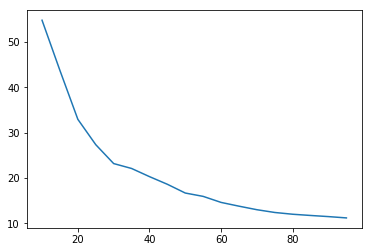

In [13]:
import matplotlib.pyplot as plt
ans = [54.77,43.68,32.91,27.32,23.15,22.07,20.27,18.58,16.65,15.91,14.58,13.75,12.97,12.36,11.97,11.70,11.45,11.16]
xaxis = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
plt.plot(xaxis,ans)

# 2nd layer 

In [7]:
def get_model(i):
    batch_norm_alpha=0.9
    batch_norm_eps=1e-4

    model=Sequential()
    print(dir(model.layers))
    print(i)
    model.add(pruned_Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid',input_shape=[32,32,3],droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid',droprate = i))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(pruned_Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(pruned_Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    #model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(Flatten())
    
    temp = pruned_Dense(512)
    temp.build([None,512])
    model.add(temp)

    model.add(Activation('relu'))

    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    
    temp = pruned_Dense(512)
    temp.build([None,512])
    model.add(temp)
    model.add(Activation('relu'))

    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    
    temp2 = pruned_Dense(10)
    temp2.build([None,512])
    model.add(temp2)
    model.add(Activation('softmax'))
    return model

In [8]:
from tensorflow.python.keras.backend import set_session
from keras.backend import manual_variable_initialization
manual_variable_initialization(False)
# 程序开始时声明
sess = tf.Session()
graph = tf.get_default_graph()

# 在model加载前添加set_session
set_session(sess)
check = [65,70,75,80,85,90,95]#10,15,20,25,30,35,40,45,50,55,60,
for i in check:
    j = i/100
    test=get_model(j)
    sess.run(tf.global_variables_initializer())
    weights_path='pretrained_cifar10.h5'
    test.load_weights(weights_path)
    for p in test.layers:
        if type(p) == pruned_Conv2D and p.droprate>0:
            tempweight = p.get_mask(p.get_weights()[0])
            #print(K.get_value(p.kernel))
            tempweight2 = p.set_mask(p.get_weights()[1])
            hoho = [tempweight,tempweight2]    
            p.set_weights(hoho)
    opt = keras.optimizers.Adam(lr=0.001,decay=1e-6)
    #now complie the prunable model with sparse categorical crossentropy loss function as you did in part 1
    #make sure weights are loaded correctly by evaluating the prunable model here and printing the output
    test.compile(optimizer=opt, 
                  loss="categorical_crossentropy" ,metrics=['accuracy'])
    #history_dropout_hidden = model.fit(data_train, labels_train, validation_data=(data_test, labels_test), epochs=50, batch_size=1000, shuffle=True)

    scores_dropout_hidden = test.evaluate(data_test, labels_test)
    print("Accuracy: %.2f%%" %(scores_dropout_hidden[1]*100))

['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']
0.65
(3, 3, 64, 64)
10000/10000 [==============================] - 36s 4ms/step
Accuracy: 62.42%
['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_

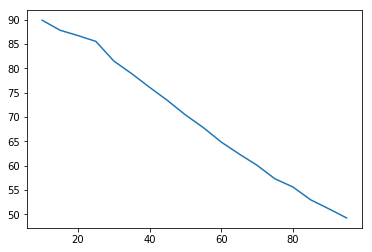

In [13]:

ans = [89.87,87.82,86.72,85.53,81.50,78.91,76.10,73.40,70.44,67.84,64.87,62.42,60.10,57.32,55.65,53.00,51.18,49.29]
xaxis = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
plt.plot(xaxis,ans)

# 3rd layer

In [7]:
def get_model(i):
    batch_norm_alpha=0.9
    batch_norm_eps=1e-4

    model=Sequential()
    print(dir(model.layers))
    print(i)
    model.add(pruned_Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid',input_shape=[32,32,3],droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(pruned_Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid',droprate = i))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(pruned_Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    #model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(Flatten())
    
    temp = pruned_Dense(512)
    temp.build([None,512])
    model.add(temp)

    model.add(Activation('relu'))

    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    
    temp = pruned_Dense(512)
    temp.build([None,512])
    model.add(temp)
    model.add(Activation('relu'))

    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    
    temp2 = pruned_Dense(10)
    temp2.build([None,512])
    model.add(temp2)
    model.add(Activation('softmax'))
    return model

In [8]:
from tensorflow.python.keras.backend import set_session
from keras.backend import manual_variable_initialization
manual_variable_initialization(False)
# 程序开始时声明
sess = tf.Session()
graph = tf.get_default_graph()

# 在model加载前添加set_session
set_session(sess)
check = [80,85,90,95]#10,15,20,25,30,35,40,45,50,55,60,65,70,75,
for i in check:
    j = i/100
    test=get_model(j)
    sess.run(tf.global_variables_initializer())
    weights_path='pretrained_cifar10.h5'
    test.load_weights(weights_path)
    for p in test.layers:
        if type(p) == pruned_Conv2D and p.droprate>0:
            tempweight = p.get_mask(p.get_weights()[0])
            #print(K.get_value(p.kernel))
            tempweight2 = p.set_mask(p.get_weights()[1])
            hoho = [tempweight,tempweight2]    
            p.set_weights(hoho)
    opt = keras.optimizers.Adam(lr=0.001,decay=1e-6)
    #now complie the prunable model with sparse categorical crossentropy loss function as you did in part 1
    #make sure weights are loaded correctly by evaluating the prunable model here and printing the output
    test.compile(optimizer=opt, 
                  loss="categorical_crossentropy" ,metrics=['accuracy'])
    #history_dropout_hidden = model.fit(data_train, labels_train, validation_data=(data_test, labels_test), epochs=50, batch_size=1000, shuffle=True)

    scores_dropout_hidden = test.evaluate(data_test, labels_test)
    print("Accuracy: %.2f%%" %(scores_dropout_hidden[1]*100))

['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']
0.8
(3, 3, 64, 128)
10000/10000 [==============================] - 41s 4ms/step
Accuracy: 9.86%
['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_e

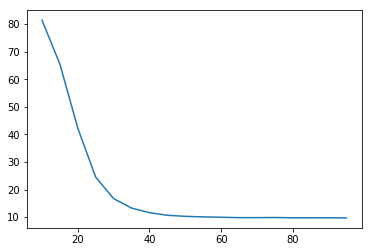

In [10]:
import matplotlib.pyplot as plt
ans = [81.42,65.44,42.21,24.46,16.71,13.28,11.61,10.67,10.28,10.08,9.95,9.81,9.81,9.86,9.76,9.74,9.78,9.71]
xaxis = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
plt.plot(xaxis,ans)

# 4th layer

In [7]:
def get_model(i):
    batch_norm_alpha=0.9
    batch_norm_eps=1e-4

    model=Sequential()
    print(dir(model.layers))
    print(i)
    model.add(pruned_Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid',input_shape=[32,32,3],droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(pruned_Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid',droprate = i))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(pruned_Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    #model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(Flatten())
    
    temp = pruned_Dense(512)
    temp.build([None,512])
    model.add(temp)

    model.add(Activation('relu'))

    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    
    temp = pruned_Dense(512)
    temp.build([None,512])
    model.add(temp)
    model.add(Activation('relu'))

    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    
    temp2 = pruned_Dense(10)
    temp2.build([None,512])
    model.add(temp2)
    model.add(Activation('softmax'))
    return model

In [8]:
from tensorflow.python.keras.backend import set_session
from keras.backend import manual_variable_initialization
manual_variable_initialization(False)
# 程序开始时声明
sess = tf.Session()
graph = tf.get_default_graph()

# 在model加载前添加set_session
set_session(sess)
check = [90,95]#10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,
for i in check:
    j = i/100
    test=get_model(j)
    sess.run(tf.global_variables_initializer())
    weights_path='pretrained_cifar10.h5'
    test.load_weights(weights_path)
    for p in test.layers:
        if type(p) == pruned_Conv2D and p.droprate>0:
            tempweight = p.get_mask(p.get_weights()[0])
            #print(K.get_value(p.kernel))
            tempweight2 = p.set_mask(p.get_weights()[1])
            hoho = [tempweight,tempweight2]    
            p.set_weights(hoho)
    opt = keras.optimizers.Adam(lr=0.001,decay=1e-6)
    #now complie the prunable model with sparse categorical crossentropy loss function as you did in part 1
    #make sure weights are loaded correctly by evaluating the prunable model here and printing the output
    test.compile(optimizer=opt, 
                  loss="categorical_crossentropy" ,metrics=['accuracy'])
    #history_dropout_hidden = model.fit(data_train, labels_train, validation_data=(data_test, labels_test), epochs=50, batch_size=1000, shuffle=True)

    scores_dropout_hidden = test.evaluate(data_test, labels_test)
    print("Accuracy: %.2f%%" %(scores_dropout_hidden[1]*100))

['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']
0.9
(3, 3, 128, 128)
10000/10000 [==============================] - 36s 4ms/step
Accuracy: 16.54%
['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce

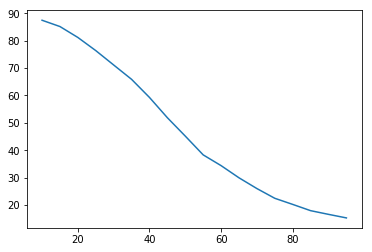

In [9]:
import matplotlib.pyplot as plt
ans = [87.48,85.18,81.19,76.39,71.13,65.89,59.27,51.86,45.14,38.28,34.35,29.90,25.97,22.41,20.18,17.89,16.54,15.24]
xaxis = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
plt.plot(xaxis,ans)

# 5th layer

In [10]:
def get_model(i):
    batch_norm_alpha=0.9
    batch_norm_eps=1e-4

    model=Sequential()
    print(dir(model.layers))
    print(i)
    model.add(pruned_Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid',input_shape=[32,32,3],droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(pruned_Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(pruned_Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid',droprate = i))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    #model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(Flatten())
    
    temp = pruned_Dense(512)
    temp.build([None,512])
    model.add(temp)

    model.add(Activation('relu'))

    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    
    temp = pruned_Dense(512)
    temp.build([None,512])
    model.add(temp)
    model.add(Activation('relu'))

    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    
    temp2 = pruned_Dense(10)
    temp2.build([None,512])
    model.add(temp2)
    model.add(Activation('softmax'))
    return model

In [11]:
from tensorflow.python.keras.backend import set_session
from keras.backend import manual_variable_initialization
manual_variable_initialization(False)
# 程序开始时声明
sess = tf.Session()
graph = tf.get_default_graph()

# 在model加载前添加set_session
set_session(sess)
check = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]#
for i in check:
    j = i/100
    test=get_model(j)
    sess.run(tf.global_variables_initializer())
    weights_path='pretrained_cifar10.h5'
    test.load_weights(weights_path)
    for p in test.layers:
        if type(p) == pruned_Conv2D and p.droprate>0:
            tempweight = p.get_mask(p.get_weights()[0])
            #print(K.get_value(p.kernel))
            tempweight2 = p.set_mask(p.get_weights()[1])
            hoho = [tempweight,tempweight2]    
            p.set_weights(hoho)
    opt = keras.optimizers.Adam(lr=0.001,decay=1e-6)
    #now complie the prunable model with sparse categorical crossentropy loss function as you did in part 1
    #make sure weights are loaded correctly by evaluating the prunable model here and printing the output
    test.compile(optimizer=opt, 
                  loss="categorical_crossentropy" ,metrics=['accuracy'])
    #history_dropout_hidden = model.fit(data_train, labels_train, validation_data=(data_test, labels_test), epochs=50, batch_size=1000, shuffle=True)

    scores_dropout_hidden = test.evaluate(data_test, labels_test)
    print("Accuracy: %.2f%%" %(scores_dropout_hidden[1]*100))

['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']
0.1
(3, 3, 128, 256)
10000/10000 [==============================] - 36s 4ms/step
Accuracy: 88.93%
['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce

(3, 3, 128, 256)
10000/10000 [==============================] - 46s 5ms/step
Accuracy: 54.63%
['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']
0.75
(3, 3, 128, 256)
10000/10000 [==============================] - 43s 4ms/step
Accuracy: 52.29%
['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__

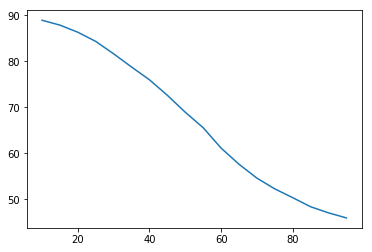

In [13]:
import matplotlib.pyplot as plt
ans = [88.93,87.87,86.32,84.33,81.63,78.77,75.99,72.62,68.94,65.58,61.15,57.65,54.63,52.29,50.38,48.41,47.08,45.98]
xaxis = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
plt.plot(xaxis,ans)

#  Layer 6

In [7]:
def get_model(i):
    batch_norm_alpha=0.9
    batch_norm_eps=1e-4

    model=Sequential()
    print(dir(model.layers))
    print(i)
    model.add(pruned_Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid',input_shape=[32,32,3],droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(pruned_Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(pruned_Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid',droprate = 0))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    model.add(pruned_Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid',droprate = i))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    #model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(Flatten())
    
    temp = pruned_Dense(512)
    temp.build([None,512])
    model.add(temp)

    model.add(Activation('relu'))

    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    
    temp = pruned_Dense(512)
    temp.build([None,512])
    model.add(temp)
    model.add(Activation('relu'))

    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
    
    temp2 = pruned_Dense(10)
    temp2.build([None,512])
    model.add(temp2)
    model.add(Activation('softmax'))
    return model

In [8]:
from tensorflow.python.keras.backend import set_session
from keras.backend import manual_variable_initialization
manual_variable_initialization(False)
# 程序开始时声明
sess = tf.Session()
graph = tf.get_default_graph()

# 在model加载前添加set_session
set_session(sess)
check = [35,40,45,50,55,60,65,70,75,80,85,90,95]#10,15,20,25,30,
for i in check:
    j = i/100
    test=get_model(j)
    sess.run(tf.global_variables_initializer())
    weights_path='pretrained_cifar10.h5'
    test.load_weights(weights_path)
    for p in test.layers:
        if type(p) == pruned_Conv2D and p.droprate>0:
            tempweight = p.get_mask(p.get_weights()[0])
            #print(K.get_value(p.kernel))
            tempweight2 = p.set_mask(p.get_weights()[1])
            hoho = [tempweight,tempweight2]    
            p.set_weights(hoho)
    opt = keras.optimizers.Adam(lr=0.001,decay=1e-6)
    #now complie the prunable model with sparse categorical crossentropy loss function as you did in part 1
    #make sure weights are loaded correctly by evaluating the prunable model here and printing the output
    test.compile(optimizer=opt, 
                  loss="categorical_crossentropy" ,metrics=['accuracy'])
    #history_dropout_hidden = model.fit(data_train, labels_train, validation_data=(data_test, labels_test), epochs=50, batch_size=1000, shuffle=True)

    scores_dropout_hidden = test.evaluate(data_test, labels_test)
    print("Accuracy: %.2f%%" %(scores_dropout_hidden[1]*100))

['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']
0.35
(3, 3, 256, 256)
10000/10000 [==============================] - 35s 3ms/step
Accuracy: 88.14%
['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduc

(3, 3, 256, 256)
10000/10000 [==============================] - 39s 4ms/step
Accuracy: 57.39%


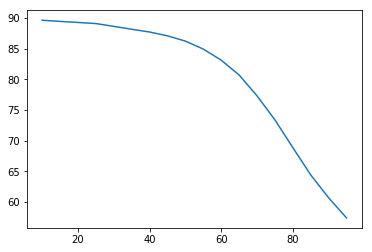

In [10]:
import matplotlib.pyplot as plt
ans = [89.61,89.42,89.25,89.07,88.61,88.14,87.69,87.07,86.21,84.91,83.10,80.69,77.29,73.37,68.85,64.40,60.67,57.39]
xaxis = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
plt.plot(xaxis,ans)